In [1]:
import geopandas as gpd
import pandas as pd
import folium
from folium.features import GeoJsonTooltip
import seaborn as sns
import matplotlib.pyplot as plt
import branca
from shapely.geometry import Point
from libpysal.weights import Queen
from esda.moran import Moran_Local


<Axes: >

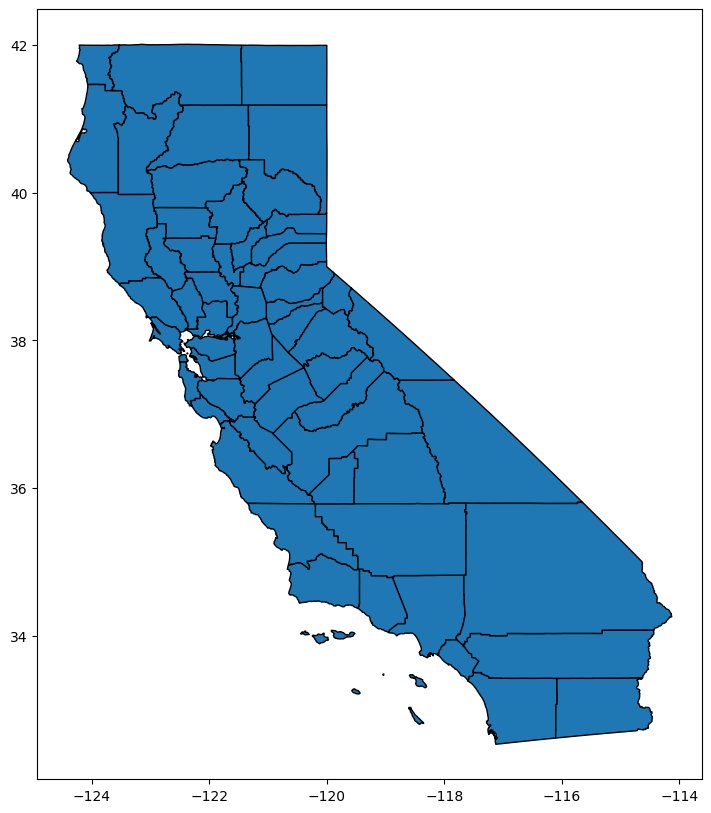

In [2]:
# Example: Use a public GeoJSON of California counties
url = "https://raw.githubusercontent.com/codeforgermany/click_that_hood/master/public/data/california-counties.geojson"
gdf = gpd.read_file(url)
gdf.plot(edgecolor="black", figsize=(10, 10))

In [3]:
df_education = pd.read_csv("education.csv")
df_education.head()

,County,FIPS,Value (Percent),People (Education: At Least Bachelor's Degree),Rank within US (of 3143 counties)
0,Lassen County,6035,13.2,3082,2886
1,Kings County,6031,13.9,13299,2810
2,Colusa County,6011,14.5,2029,2745
3,Merced County,6047,14.8,25346,2710
4,Tulare County,6107,15.8,45102,2537


In [4]:
df_education["County"] = df_education["County"].str.replace(' County', '', regex=False)

In [5]:
df_income = pd.read_csv("income.csv")
df_income.head()

,County,FIPS,Value (Dollars),Rank within US (of 3139 counties)
0,Modoc County,6049,62857,2728
1,Imperial County,6025,64569,2641
2,Tulare County,6107,71096,2285
3,Siskiyou County,6093,71583,2238
4,Merced County,6047,73010,2136


In [6]:
df_income["County"] = df_income["County"].str.replace(' County', '', regex=False)

In [7]:
gdf.head()

,name,cartodb_id,created_at,updated_at,geometry
0,Alameda,1,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"MULTIPOLYGON (((-122.31293 37.89733, -122.2884..."
1,Alpine,2,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-120.07239 38.70277, -119.96495 38.7..."
2,Amador,3,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-121.02726 38.48925, -121.02741 38.5..."
3,Butte,4,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-121.87925 39.30361, -121.90831 39.3..."
4,Calaveras,5,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-120.87605 38.02889, -120.91875 38.0..."


In [8]:
# Merge education + income into one DataFrame
df_education = df_education.rename(columns={
    "County": "name",
    "Value (Percent)": "bachelor_or_higher_pct",
    "People (Education: At Least Bachelor's Degree)": "bachelor_or_higher_count"
})

df_income = df_income.rename(columns={
    "County": "name",
    "Value (Dollars)": "median_income"
})

merged_df = pd.merge(
    df_education[["name", "bachelor_or_higher_pct", "bachelor_or_higher_count"]],
    df_income[["name", "median_income"]],
    on="name", how="outer"
)

# Merge with your GeoDataFrame
gdf_merged = gdf.merge(merged_df, on="name", how="left")


In [9]:
gdf_merged.iloc[0]

name                                                                  Alameda
cartodb_id                                                                  1
created_at                                          2015-07-04 21:04:58+00:00
updated_at                                          2015-07-04 21:04:58+00:00
geometry                    MULTIPOLYGON (((-122.312934 37.897333, -122.28...
bachelor_or_higher_pct                                                   51.5
bachelor_or_higher_count                                               612435
median_income                                                          155116
Name: 0, dtype: object

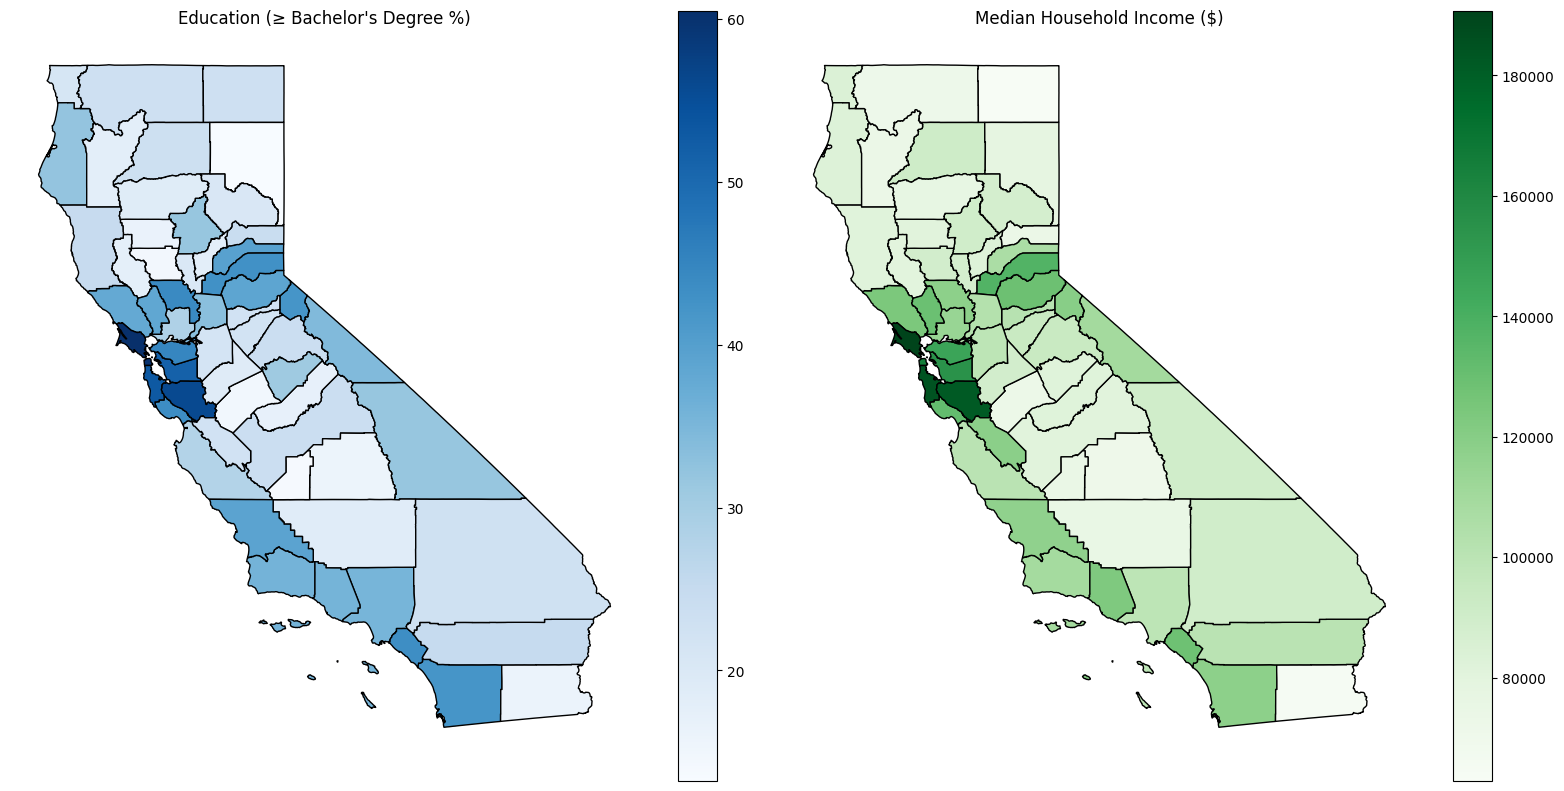

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

gdf_merged.plot(
    column="bachelor_or_higher_pct",
    cmap="Blues",
    legend=True,
    ax=axes[0],
    edgecolor="black"
)
axes[0].set_title("Education (≥ Bachelor's Degree %)")
axes[0].axis("off")

gdf_merged.plot(
    column="median_income",
    cmap="Greens",
    legend=True,
    ax=axes[1],
    edgecolor="black"
)
axes[1].set_title("Median Household Income ($)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

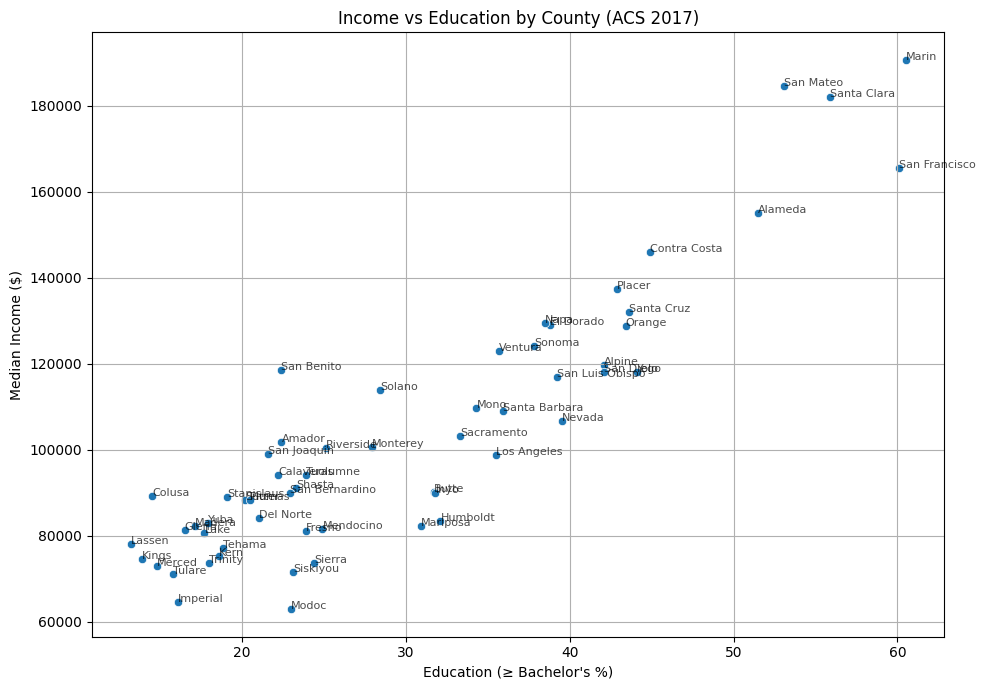

In [11]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=gdf_merged,
    x="bachelor_or_higher_pct",
    y="median_income"
)

# Annotate counties
for _, row in gdf_merged.iterrows():
    plt.text(
        row["bachelor_or_higher_pct"],
        row["median_income"],
        row["name"],
        fontsize=8,
        alpha=0.7
    )

plt.xlabel("Education (≥ Bachelor's %)")
plt.ylabel("Median Income ($)")
plt.title("Income vs Education by County (ACS 2017)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
gdf_merged["created_at"] = gdf_merged["created_at"].astype(str)
gdf_merged["updated_at"] = gdf_merged["updated_at"].astype(str)

In [13]:
import folium
import branca
import geopandas as gpd
from shapely.geometry import Point

# Step 1: Project to metric CRS for safe centroid computation
gdf_projected = gdf_merged.to_crs(epsg=3310)
center = gdf_projected.geometry.centroid.union_all().centroid

# Step 2: Reproject center to EPSG:4326 for folium display
center_gdf = gpd.GeoSeries([center], crs=3310).to_crs(epsg=4326)
center_latlon = center_gdf.geometry[0]

# Step 3: Reproject the full GeoDataFrame to EPSG:4326 for Folium
gdf_display = gdf_merged.to_crs(epsg=4326)

# Step 4: Initialize map with reprojected center
m = folium.Map(location=[center_latlon.y, center_latlon.x], zoom_start=6)

# Step 5: Create colormap
edu_colormap = branca.colormap.linear.Blues_09.scale(
    gdf_display["bachelor_or_higher_pct"].min(),
    gdf_display["bachelor_or_higher_pct"].max()
)
edu_colormap.caption = "Bachelor's Degree (%)"

# Step 6: Add education layer
folium.GeoJson(
    gdf_display,
    style_function=lambda feature: {
        'fillColor': edu_colormap(feature['properties']['bachelor_or_higher_pct']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "bachelor_or_higher_pct"],
        aliases=["County", "Bachelor's Degree %"],
        sticky=True
    )
).add_to(m)

# Step 7: Add colormap legend
edu_colormap.add_to(m)

# Step 8: Display the map
m


In [14]:
# Step 1: Project to metric CRS and compute safe centroid
gdf_projected = gdf_merged.to_crs(epsg=3310)
center = gdf_projected.geometry.centroid.union_all().centroid

# Step 2: Reproject center for folium
center_gdf = gpd.GeoSeries([center], crs=3310).to_crs(epsg=4326)
center_latlon = center_gdf.geometry[0]

# Step 3: Prepare display GeoDataFrame
gdf_display = gdf_merged.to_crs(epsg=4326)

# Step 4: Initialize map
m = folium.Map(location=[center_latlon.y, center_latlon.x], zoom_start=6)

# Step 5: Create colormaps
edu_colormap = branca.colormap.linear.Blues_09.scale(
    gdf_display["bachelor_or_higher_pct"].min(),
    gdf_display["bachelor_or_higher_pct"].max()
)
edu_colormap.caption = "Bachelor's Degree (%)"

income_colormap = branca.colormap.linear.Greens_09.scale(
    gdf_display["median_income"].min(),
    gdf_display["median_income"].max()
)
income_colormap.caption = "Median Household Income ($)"

# Step 6: Education layer
edu_layer = folium.FeatureGroup(name="Bachelor's Degree %", show=True)

folium.GeoJson(
    gdf_display,
    style_function=lambda feature: {
        'fillColor': edu_colormap(feature['properties']['bachelor_or_higher_pct']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "bachelor_or_higher_pct"],
        aliases=["County", "Bachelor's Degree %"],
        sticky=True
    )
).add_to(edu_layer)

edu_layer.add_to(m)
edu_colormap.add_to(m)

# Step 7: Income layer
income_layer = folium.FeatureGroup(name="Median Income ($)", show=False)

folium.GeoJson(
    gdf_display,
    style_function=lambda feature: {
        'fillColor': income_colormap(feature['properties']['median_income']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "median_income"],
        aliases=["County", "Median Income ($)"],
        sticky=True
    )
).add_to(income_layer)

income_layer.add_to(m)
income_colormap.add_to(m)

# Step 8: Layer toggle
folium.LayerControl(collapsed=False).add_to(m)

# Step 9: Display
m


In [15]:
# Step 1: Safe centroid using projected CRS
gdf_projected = gdf_merged.to_crs(epsg=3310)
center = gdf_projected.geometry.centroid.union_all().centroid
center_gdf = gpd.GeoSeries([center], crs=3310).to_crs(epsg=4326)
center_latlon = center_gdf.geometry[0]

# Step 2: Reproject full GeoDataFrame for folium
gdf_display = gdf_merged.to_crs(epsg=4326)

# Step 3: Compute income-to-education ratio
gdf_display["income_edu_ratio"] = gdf_display["median_income"] / gdf_display["bachelor_or_higher_pct"]

# Step 4: Initialize folium map
m = folium.Map(location=[center_latlon.y, center_latlon.x], zoom_start=6)

# Step 5: Colormaps
edu_colormap = branca.colormap.linear.Blues_09.scale(
    gdf_display["bachelor_or_higher_pct"].min(),
    gdf_display["bachelor_or_higher_pct"].max()
)
edu_colormap.caption = "Bachelor's Degree (%)"

income_colormap = branca.colormap.linear.Greens_09.scale(
    gdf_display["median_income"].min(),
    gdf_display["median_income"].max()
)
income_colormap.caption = "Median Household Income ($)"

ratio_colormap = branca.colormap.linear.Purples_09.scale(
    gdf_display["income_edu_ratio"].min(),
    gdf_display["income_edu_ratio"].max()
)
ratio_colormap.caption = "Income / % Bachelor's Degree"

# Step 6: Education layer
edu_layer = folium.FeatureGroup(name="Bachelor's Degree %", show=True)
folium.GeoJson(
    gdf_display,
    style_function=lambda f: {
        'fillColor': edu_colormap(f["properties"]["bachelor_or_higher_pct"]),
        'color': 'black', 'weight': 0.5, 'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "bachelor_or_higher_pct"],
        aliases=["County", "Bachelor's Degree %"],
        sticky=True
    )
).add_to(edu_layer)
edu_layer.add_to(m)
edu_colormap.add_to(m)

# Step 7: Income layer
income_layer = folium.FeatureGroup(name="Median Income ($)", show=False)
folium.GeoJson(
    gdf_display,
    style_function=lambda f: {
        'fillColor': income_colormap(f["properties"]["median_income"]),
        'color': 'black', 'weight': 0.5, 'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "median_income"],
        aliases=["County", "Median Income ($)"],
        sticky=True
    )
).add_to(income_layer)
income_layer.add_to(m)
income_colormap.add_to(m)

# Step 8: Income/Education Ratio layer
ratio_layer = folium.FeatureGroup(name="Income per % Educated", show=False)
folium.GeoJson(
    gdf_display,
    style_function=lambda f: {
        'fillColor': ratio_colormap(f["properties"]["income_edu_ratio"]),
        'color': 'black', 'weight': 0.5, 'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "income_edu_ratio"],
        aliases=["County", "Income / Bachelor's %"],
        sticky=True
    )
).add_to(ratio_layer)
ratio_layer.add_to(m)
ratio_colormap.add_to(m)

# Step 9: Layer toggle control
folium.LayerControl(collapsed=False).add_to(m)

# Show map
m

In [16]:
def compute_lisa_ratio(gdf, col="income_edu_ratio"):
    from libpysal.weights import Queen
    from esda.moran import Moran_Local

    w = Queen.from_dataframe(gdf, use_index=False)
    lisa = Moran_Local(gdf[col], w)
    gdf["lisa_ratio_cluster"] = lisa.q
    gdf["lisa_ratio_sig"] = lisa.p_sim < 0.05
    gdf["lisa_ratio_label"] = gdf["lisa_ratio_cluster"].map({
        1: "High-High",
        2: "Low-Low",
        3: "High-Low",
        4: "Low-High"
    })
    return gdf


In [17]:
gdf_display = compute_lisa_ratio(gdf_display)

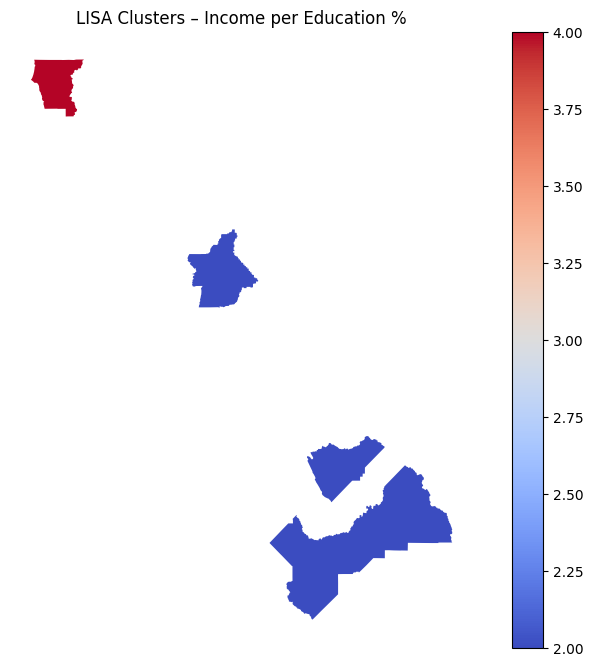

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_display[gdf_display["lisa_ratio_sig"]].plot(
    column="lisa_ratio_cluster", cmap="coolwarm", legend=True, ax=ax
)
ax.set_title("LISA Clusters – Income per Education %")
plt.axis("off")
plt.show()

In [19]:
significant_lisa = gdf_display[gdf_display["lisa_ratio_sig"]]
significant_lisa[["name", "lisa_ratio_label", "income_edu_ratio"]].sort_values("income_edu_ratio", ascending=False)

,name,lisa_ratio_label,income_edu_ratio
7,Del Norte,Low-High,4008.952381
10,Fresno,Low-Low,3391.966527
3,Butte,Low-Low,2840.599369
24,Mariposa,Low-Low,2661.100324


In [20]:
outliers = gdf_display[
    (gdf_display["lisa_ratio_sig"]) &
    (gdf_display["lisa_ratio_label"].isin(["High-Low", "Low-High"]))
]

In [21]:
outliers[["name", "income_edu_ratio", "lisa_ratio_label"]]

,name,income_edu_ratio,lisa_ratio_label
7,Del Norte,4008.952381,Low-High


In [22]:
import folium
import branca
import geopandas as gpd
from shapely.geometry import Point
from libpysal.weights import Queen
from esda.moran import Moran_Local

# Step 1: Safe centroid using projected CRS
gdf_projected = gdf_merged.to_crs(epsg=3310)
center = gdf_projected.geometry.centroid.union_all().centroid
center_gdf = gpd.GeoSeries([center], crs=3310).to_crs(epsg=4326)
center_latlon = center_gdf.geometry[0]

# Step 2: Reproject full GeoDataFrame for folium
gdf_display = gdf_merged.to_crs(epsg=4326)

# Step 3: Compute income-to-education ratio
gdf_display["income_edu_ratio"] = gdf_display["median_income"] / gdf_display["bachelor_or_higher_pct"]

# Step 4: Run PySAL LISA on income/education ratio
w = Queen.from_dataframe(gdf_display, use_index=False)
y = gdf_display["income_edu_ratio"]
lisa = Moran_Local(y, w)
gdf_display["lisa_ratio_cluster"] = lisa.q
gdf_display["lisa_ratio_sig"] = lisa.p_sim < 0.05
gdf_display["lisa_ratio_label"] = gdf_display["lisa_ratio_cluster"].map({
    1: "High-High",
    2: "Low-Low",
    3: "High-Low",
    4: "Low-High"
})

# Step 5: Initialize folium map
m = folium.Map(location=[center_latlon.y, center_latlon.x], zoom_start=6)

# Step 6: Colormaps
edu_colormap = branca.colormap.linear.Blues_09.scale(
    gdf_display["bachelor_or_higher_pct"].min(),
    gdf_display["bachelor_or_higher_pct"].max()
)
edu_colormap.caption = "Bachelor's Degree (%)"

income_colormap = branca.colormap.linear.Greens_09.scale(
    gdf_display["median_income"].min(),
    gdf_display["median_income"].max()
)
income_colormap.caption = "Median Household Income ($)"

ratio_colormap = branca.colormap.linear.Purples_09.scale(
    gdf_display["income_edu_ratio"].min(),
    gdf_display["income_edu_ratio"].max()
)
ratio_colormap.caption = "Income / % Bachelor's Degree"

# Custom colors for LISA
lisa_colors = {
    1: "darkred",    # High-High
    2: "darkblue",   # Low-Low
    3: "orange",     # High-Low
    4: "green"       # Low-High
}

# Step 7: Education layer
edu_layer = folium.FeatureGroup(name="Bachelor's Degree %", show=True)
folium.GeoJson(
    gdf_display,
    style_function=lambda f: {
        'fillColor': edu_colormap(f["properties"]["bachelor_or_higher_pct"]),
        'color': 'black', 'weight': 0.5, 'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "bachelor_or_higher_pct"],
        aliases=["County", "Bachelor's Degree %"],
        sticky=True
    )
).add_to(edu_layer)
edu_layer.add_to(m)
edu_colormap.add_to(m)

# Step 8: Income layer
income_layer = folium.FeatureGroup(name="Median Income ($)", show=False)
folium.GeoJson(
    gdf_display,
    style_function=lambda f: {
        'fillColor': income_colormap(f["properties"]["median_income"]),
        'color': 'black', 'weight': 0.5, 'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "median_income"],
        aliases=["County", "Median Income ($)"],
        sticky=True
    )
).add_to(income_layer)
income_layer.add_to(m)
income_colormap.add_to(m)

# Step 9: Income/Education Ratio layer
ratio_layer = folium.FeatureGroup(name="Income per % Educated", show=False)
folium.GeoJson(
    gdf_display,
    style_function=lambda f: {
        'fillColor': ratio_colormap(f["properties"]["income_edu_ratio"]),
        'color': 'black', 'weight': 0.5, 'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "income_edu_ratio"],
        aliases=["County", "Income / Bachelor's %"],
        sticky=True
    )
).add_to(ratio_layer)
ratio_layer.add_to(m)
ratio_colormap.add_to(m)

# Step 10: LISA Cluster layer (only significant clusters)
lisa_layer = folium.FeatureGroup(name="LISA Cluster: Income/Education", show=False)
significant = gdf_display[gdf_display["lisa_ratio_sig"]]

folium.GeoJson(
    significant,
    style_function=lambda f: {
        'fillColor': lisa_colors.get(f["properties"]["lisa_ratio_cluster"], "gray"),
        'color': 'black', 'weight': 0.5, 'fillOpacity': 0.8
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "lisa_ratio_label", "income_edu_ratio"],
        aliases=["County", "LISA Cluster", "Income/Edu Ratio"],
        sticky=True
    )
).add_to(lisa_layer)
lisa_layer.add_to(m)

# Step 11: Layer toggle control
folium.LayerControl(collapsed=False).add_to(m)

# Step 12: Show map
m


In [24]:
gdf_display["income_edu_ratio"] = gdf_display["median_income"] / gdf_display["bachelor_or_higher_pct"]
gdf_display["income_unedu_ratio"] = gdf_display["median_income"] / (100 - gdf_display["bachelor_or_higher_pct"])
gdf_display["edu_efficiency_index"] = gdf_display["income_edu_ratio"] / gdf_display["income_unedu_ratio"]

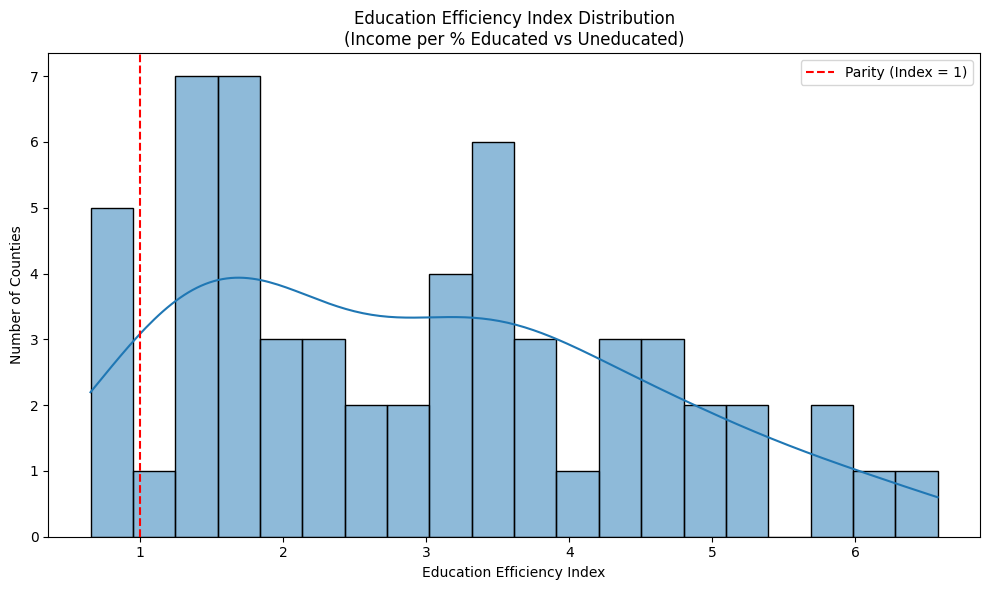

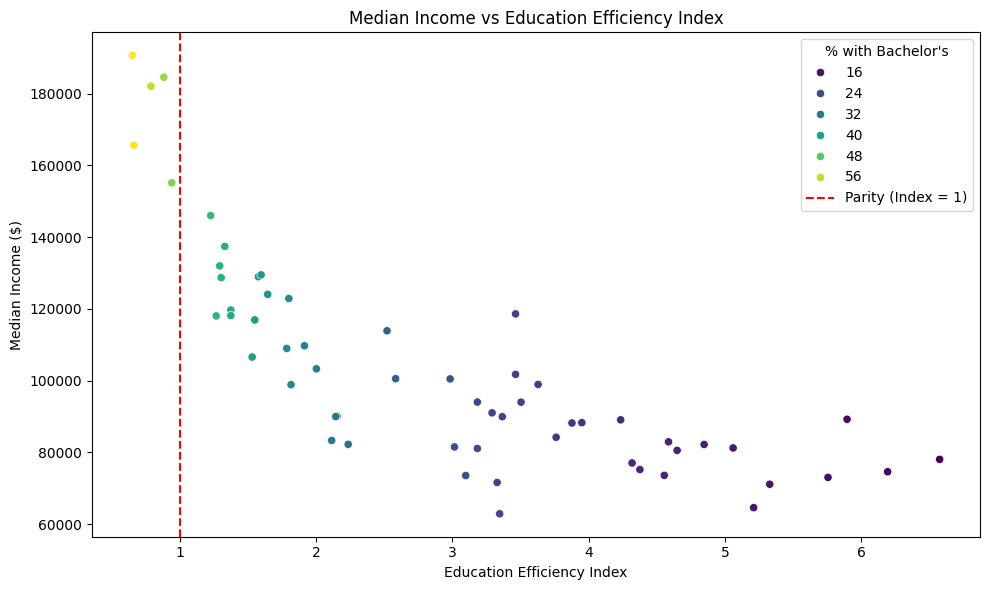

,name,edu_efficiency_index,lisa_eff_label
27,Modoc,3.347826,High-High
31,Shasta,3.291845,High-High
10,Fresno,3.184100,High-High
19,Solano,2.521127,High-Low
24,Mariposa,2.236246,Low-Low
3,Butte,2.154574,Low-Low
37,San Mateo,0.883239,High-Low


In [25]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(gdf_display["edu_efficiency_index"], bins=20, kde=True)
plt.axvline(1, color="red", linestyle="--", label="Parity (Index = 1)")
plt.title("Education Efficiency Index Distribution\n(Income per % Educated vs Uneducated)")
plt.xlabel("Education Efficiency Index")
plt.ylabel("Number of Counties")
plt.legend()
plt.tight_layout()
plt.show()

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=gdf_display,
    x="edu_efficiency_index",
    y="median_income",
    hue="bachelor_or_higher_pct",
    palette="viridis"
)
plt.axvline(1, color="red", linestyle="--", label="Parity (Index = 1)")
plt.title("Median Income vs Education Efficiency Index")
plt.xlabel("Education Efficiency Index")
plt.ylabel("Median Income ($)")
plt.legend(title="% with Bachelor's")
plt.tight_layout()
plt.show()

# LISA on efficiency index
w = Queen.from_dataframe(gdf_display, use_index=False)
y_eff = gdf_display["edu_efficiency_index"]
lisa_eff = Moran_Local(y_eff, w)

gdf_display["lisa_eff_cluster"] = lisa_eff.q
gdf_display["lisa_eff_sig"] = lisa_eff.p_sim < 0.05
gdf_display["lisa_eff_label"] = gdf_display["lisa_eff_cluster"].map({
    1: "High-High",
    2: "Low-Low",
    3: "High-Low",
    4: "Low-High"
})

# Show significant outliers
significant_eff = gdf_display[gdf_display["lisa_eff_sig"]][
    ["name", "edu_efficiency_index", "lisa_eff_label"]
].sort_values("edu_efficiency_index", ascending=False)

display(significant_eff)

In [26]:
target = gdf_display[
    (gdf_display["edu_efficiency_index"] > 3) &
    (gdf_display["edu_efficiency_index"] < 4) &
    (gdf_display["median_income"] > 115000) &
    (gdf_display["bachelor_or_higher_pct"] < 25)  # purple-ish
]

target[["name", "median_income", "bachelor_or_higher_pct", "edu_efficiency_index"]]


,name,median_income,bachelor_or_higher_pct,edu_efficiency_index
54,San Benito,118578,22.4,3.464286
